In [21]:
#######################
### L03 - Exercises ###
#######################

# importing libraries and setting up nice plots

import random
import numpy as np
import matplotlib.pyplot        as     plt
import matplotlib.patches       as     patches
import matplotlib.ticker		as     tck
import matplotlib.colors		as     colors
from   matplotlib				import rc
from   matplotlib.ticker		import FormatStrFormatter, MultipleLocator, FuncFormatter
from   matplotlib.gridspec		import GridSpec
from   scipy.stats              import norm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : ["Times New Roman"],
	"font.size"  : 15
    })
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')

In [ ]:
##################################################
### L03 - Exercise 1: MMonte Carlo integration ###
##################################################

Using Monte Carlo Integration, verify that:

$$
    I = 
    \int_0^\infty 
    \, \textup{d}x 
    \; x^3 \exp\!\!\bigg( \!\!
        -\frac{1}{2} \frac{x^2}{\sigma^2}
    \bigg)
    = 2 \sigma^4
$$

Our goal is to write the integral as:

$$
    I = \int_0^\infty 
    \, \textup{d}x 
    \; f(x) \, \textup{pdf}(x)
$$

We recognise something similar to a Normal distribution $\mathcal{N}(\mu = 0,\sigma)$ in the exponential factor. However, the integration domain is $(0,+\infty)$, so we must take as $\textup{pdf}(x)$ a truncated Normal distribution only for $x \geq 0$. Note that the area of such a truncated Normal is only $\frac{1}{2}$, so the pdf must be corrected:


$$
\textup{pdf}(x) 
= \begin{cases}
    2\,\dfrac{1}{\sigma \sqrt{2\pi}} 
  \exp\!\!\bigg( \!\!
        -\dfrac{1}{2} \dfrac{x^2}{\sigma^2}
  \bigg)
  & \textup{ if } x \geq 0
  \\
  0 & \textup{ if } x < 0
\end{cases} 
$$ 

$$
% \mathcal{N}(\mu = 0,\sigma)
% = \frac{1}{\sigma \sqrt{2\pi}} 
%   \exp\!\!\bigg( \!\!
%         -\frac{1}{2} \frac{x^2}{\sigma^2}
%   \bigg)
$$

so that the function $f(x)$ becomes

$$
f(x) = \sigma \sqrt{\dfrac{\pi}{2}} \, x^3
$$

With Monte Carlo integration we then define the following unbiased estimator for $I$:

$$
    I \approx 
    \sqrt{\frac{2}{\pi}}
    \frac{ \sigma }{N} \,\sum_{i\,=\,1}^N x_i^3 
    \quad \textup{with } x_i \textup{ drawn from } % \quad 
    \textup{pdf}(x)
    % \mathcal{N}(\mu = 0,\sigma)
$$

In [20]:
N = [ int(1e4), int(1e5), int(1e6), int(1e7), int(1e8) ]

# above, we have rewritten the integrand as f * pdf

# use an intermediate pdf, a Gaussian distr centered in 0 with non0 sigma
sigma = 1
mean  = 0
distr_gauss = norm(mean,sigma)

# extract a sample x of size N from the Gaussian distr
# note: the integral domain is (0, +infty)
#       the Gaussian distr domain is (-infty, +infty)
#       the Gaussian distr is symmetric
# then let's take the absolute value of x sampled from the usual Gaussian
# remember to correct for the wrong normalisation
# evaluate the function f on the sample x, then I approx mean(f)
# note: we repeat and average the procedure 10 times for each different N

print("Analytic integral = {:.4f}".format(2 * sigma**4))

I_full = []
I = []
S = []
for n in N:
    i = np.zeros(100)
    for t in range(len(i)):
        x = np.array( distr_gauss.rvs(n) )
        x = np.abs(x)
        f = sigma * np.sqrt(np.pi/2) * x**3
        i[t] = np.mean(f)
    I_full.append(i)
    i_avg100 = np.mean(i)
    I.append(i_avg100)
    s_avg100 = np.std(i) / np.sqrt(len(i))
    S.append(s_avg100)
    print(
        "N = {:.0e} Monte Carlo integral = {:.10f} +- {:.10f}"
        .format(float(n), i_avg100, s_avg100)
        )



Analytic integral = 2.0000
N = 1e+04 Monte Carlo integral = 2.0036357736 +- 0.0041103546
N = 1e+05 Monte Carlo integral = 2.0028179022 +- 0.0012423214
N = 1e+06 Monte Carlo integral = 2.0001448169 +- 0.0004316139
N = 1e+07 Monte Carlo integral = 2.0000599009 +- 0.0001295587
N = 1e+08 Monte Carlo integral = 2.0000160489 +- 0.0000418560


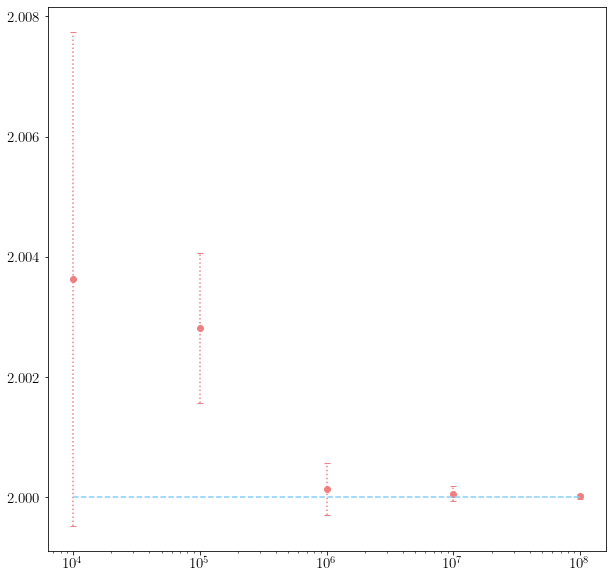

: 

In [32]:
fig , ax = plt.subplots(figsize=(10,10))

ax.set_xscale('log')
# ax.set_yscale('log')

Nx = np.array(N)
Ix = np.array(I)
Sx = np.array(S)


ax.plot(N,I, ls='', marker='o', color='lightcoral')
ax.plot(Nx,Ix+Sx, ls='', marker='_', color='lightcoral')
ax.plot(Nx,Ix-Sx, ls='', marker='_', color='lightcoral')
ax.vlines(Nx, ymin=Ix-Sx, ymax=Ix+Sx, ls=':', color='lightcoral')
ax.hlines(2, xmin=1e4, xmax=1e8, ls='--', color='lightskyblue')


In [ ]:
import matplotlib.pyplot as plt

d = [0, 1, 2, 3, 4]
c = [109, 65, 22, 3, 1]

